In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

### Problem 1. Hidden Markov Models (30pts). 
Assume that we have the Hidden Markov Model (HMM) depicted in the figure below. The transition, emission and prior probabilities are given in the table below.

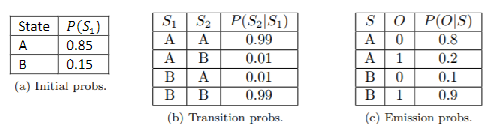

#### a)
If each of the states can take on 𝑘 different values and a total of 𝑚 different observations are
possible (across all states), how many parameters are required to fully define this HMM? Justify
your answer (5pts).

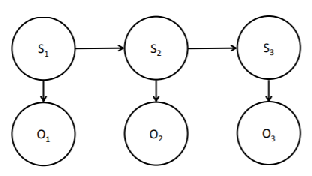

#### Answer

* If the initial probabilities is given as k,

* Transitional probabilities in this instance would be k x k, which would be a 2 x 2 matrix with A and B on both x and y axis.

* Emission probability in this instace would be k x m which is a 2 x 2 matrix with A and B on the x axis, and o=1 and o=0 on the y axis.

The total parameters for this problem would be the following:

* <b>k + (k x k) + (k x m)</b>

#### b)

Using the forward algorithm, compute the probability that we observe the sequence 𝑂1 = 1, 𝑂2 = 1, 𝑎𝑛𝑑 𝑂3 = 0. Show your work (i.e., show each of your alphas) (10pts).

In [80]:
# Define initial probability matrix
initial_probs = pd.Series([0.85, 0.15], index=['A', 'B'])

# Define transition probability matrix
transition_probs = pd.DataFrame({
    'A': {'A': 0.99, 'B': 0.01},
    'B': {'A': 0.01, 'B': 0.99}
})

# Define emission probability matrix
emission_probs = pd.DataFrame({
    'o=1': {'A': 0.2, 'B': 0.9},
    'o=0': {'A': 0.8, 'B': 0.1}
})

In [81]:
# Define the sequence of observations
observations = ['o=1', 'o=1', 'o=0']

# Create an empty array to store the forward probabilities
alpha = np.zeros((len(observations), len(initial_probs)))

# Initialize the first column of the alpha matrix
alpha[0] = initial_probs * emission_probs.loc[:, observations[0]]

# Compute the forward probabilities for the remaining columns
for t in range(1, len(observations)):
    for j in range(len(initial_probs)):
        alpha[t, j] = emission_probs.loc[:, observations[t]].iloc[j] * \
                      np.sum(alpha[t-1, :] * transition_probs.iloc[:, j])
        
# Compute the total probability of observing the sequence
p_obs = np.sum(alpha[-1])

print("Forward algorithm results:")
print(alpha)
print("The probability of observing the sequence (1, 1, 0) is:", p_obs)


Forward algorithm results:
[[0.17       0.135     ]
 [0.03393    0.121815  ]
 [0.02784708 0.01209362]]
The probability of observing the sequence (1, 1, 0) is: 0.039940695000000005


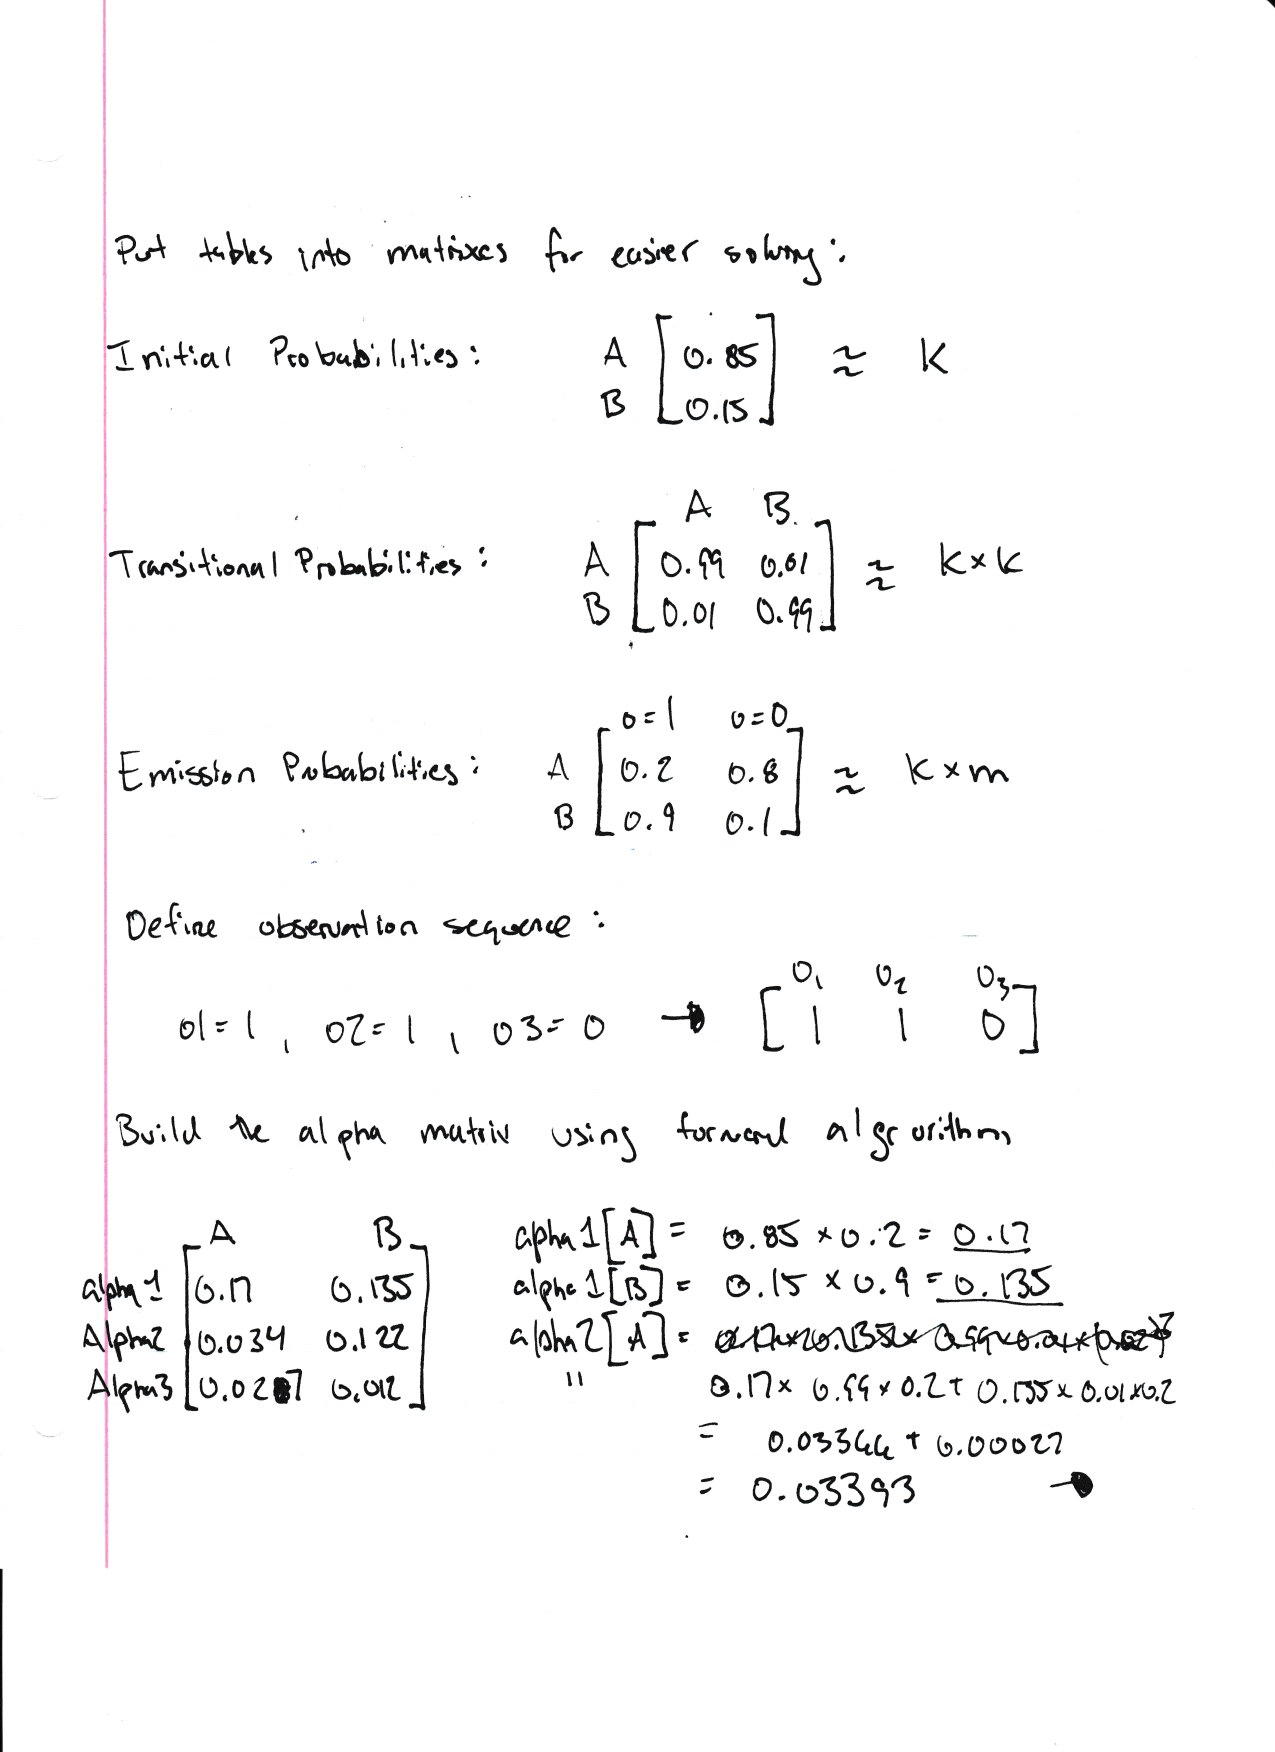

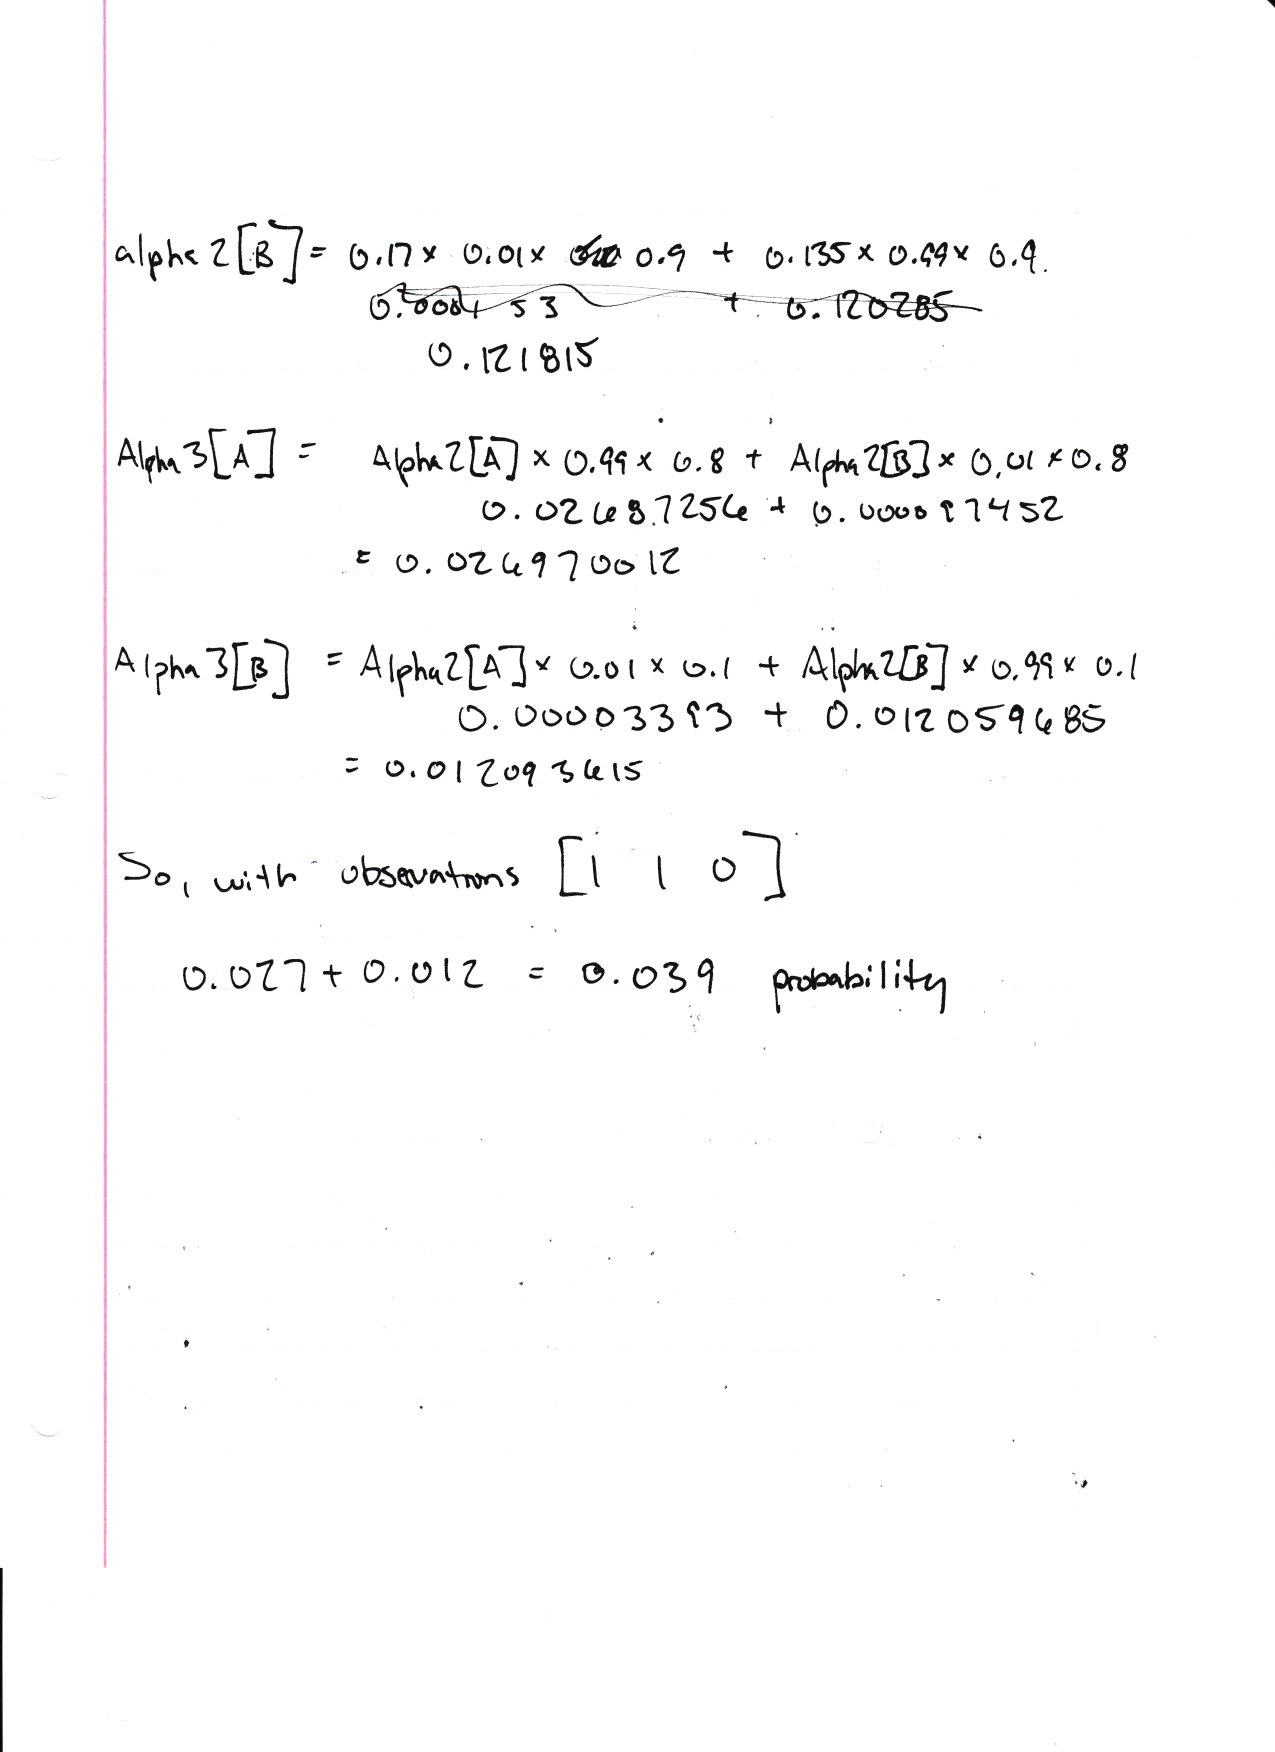

In [82]:
# Define the sequence of observations
observations = ['o=1', 'o=1', 'o=0']

# Create an empty array to store the Viterbi probabilities
Vs = np.zeros((len(observations), len(initial_probs)))

# Create an empty array to store the most likely state sequence
state_sequence = np.zeros(len(observations), dtype=int)

# Initialize the first column of the Viterbi matrix
Vs[0] = initial_probs * emission_probs.loc[:, observations[0]]

# Compute the Viterbi probabilities for the remaining columns
for t in range(1, len(observations)):
    for j in range(len(initial_probs)):
        prob = Vs[t-1] * transition_probs.iloc[:, j] * emission_probs.loc[:, observations[t]].iloc[j]
        Vs[t, j] = np.max(prob)
        state_sequence[t] = np.argmax(prob)

# Find the index of the final state with the highest Viterbi probability
final_state = np.argmax(Vs[-1])

# Backtrack to find the most likely state sequence
state_sequence[-1] = final_state
for t in range(len(observations)-2, -1, -1):
    state_sequence[t] = np.argmax(transition_probs.iloc[:, state_sequence[t+1]] * Vs[t])

# Convert the state sequence from integers to labels
state_sequence = pd.Series(state_sequence).map({0: 'A', 1: 'B'})

# Compute the total probability of observing the sequence
p_obs = np.max(Vs[-1])

print("Viterbi algorithm results:")
print(Vs)
print("The most likely state sequence is:", state_sequence.values)
print("The probability of the most likely state sequence is:", p_obs)

Viterbi algorithm results:
[[0.17       0.135     ]
 [0.03366    0.120285  ]
 [0.02665872 0.01190822]]
The most likely state sequence is: ['A' 'A' 'A']
The probability of the most likely state sequence is: 0.026658720000000004


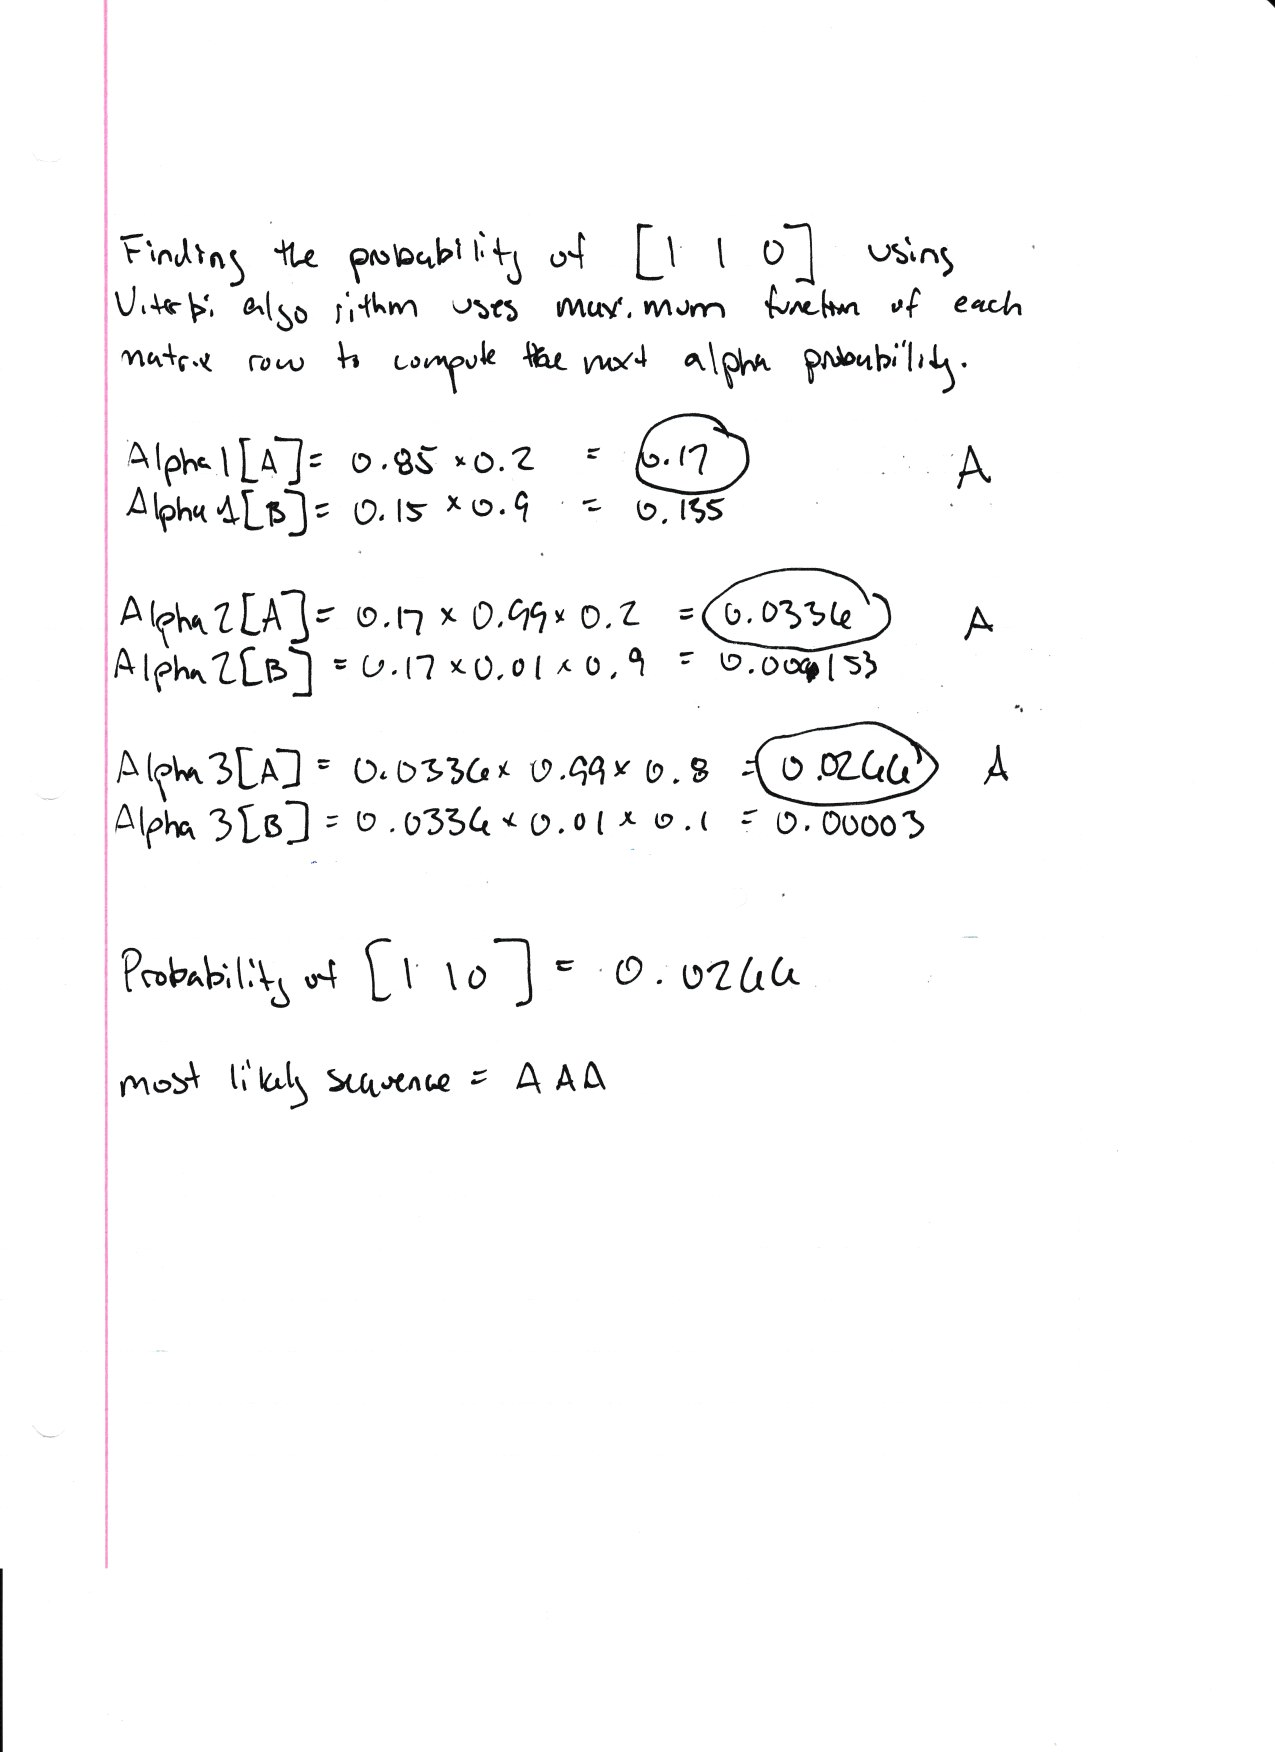

### Problem 2. Modeling Data (20pts). 
Download the data file called geyser.txt from the course website. This is a sequence of 295 consecutive measurements of two variables from Old Faithful geyser in Yellowstone National Park: the duration of the current eruption in minutes (to nearest 0.1 minute), and the waiting time until the next eruption in minutes (to nearest minute).

In [83]:
url = 'https://raw.githubusercontent.com/jmrieck17/CSC-7810-Homework-2/main/geyser.txt'
df = pd.read_csv(url, sep='\t', header=None)
df = df.dropna(axis=1)
df = df.rename(columns={0: 'Eruption_Time', 2: 'Eruption_Wait_Time'})

#### a)
Examine the data by plotting the variables within and between consecutive time steps. E.g. plot(geyser(1:end 1,1),geyser(2:end,1),’o’); (10pts).

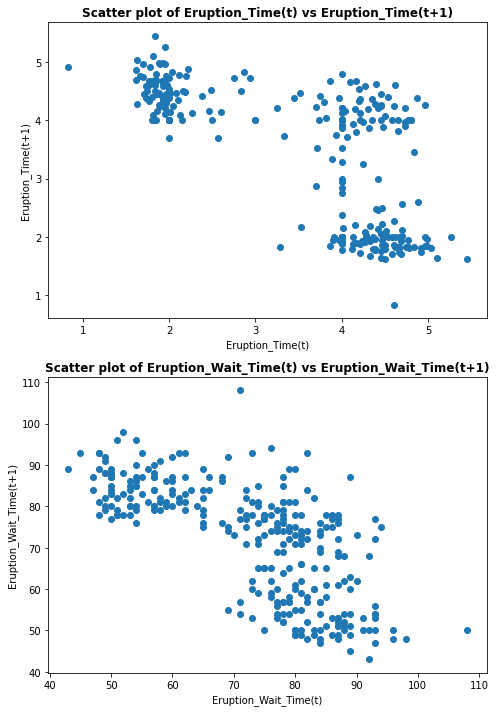

In [84]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7,10))

# First plot
ax1.scatter(df['Eruption_Time'].iloc[:-1], df['Eruption_Time'].iloc[1:], marker='o')
ax1.set_xlabel('Eruption_Time(t)')
ax1.set_ylabel('Eruption_Time(t+1)')
ax1.set_title('Scatter plot of Eruption_Time(t) vs Eruption_Time(t+1)', fontweight='bold')

# Second plot
ax2.scatter(df['Eruption_Wait_Time'].iloc[:-1], df['Eruption_Wait_Time'].iloc[1:], marker='o')
ax2.set_xlabel('Eruption_Wait_Time(t)')
ax2.set_ylabel('Eruption_Wait_Time(t+1)')
ax2.set_title('Scatter plot of Eruption_Wait_Time(t) vs Eruption_Wait_Time(t+1)', fontweight='bold')

plt.tight_layout()
plt.show()

#### b)
Discuss and justify based on your observations what kind of model might be most appropriate for this data set: e.g. a mixture of Gaussians, a hidden Markov model, a linear dynamical system, etc (10pts).

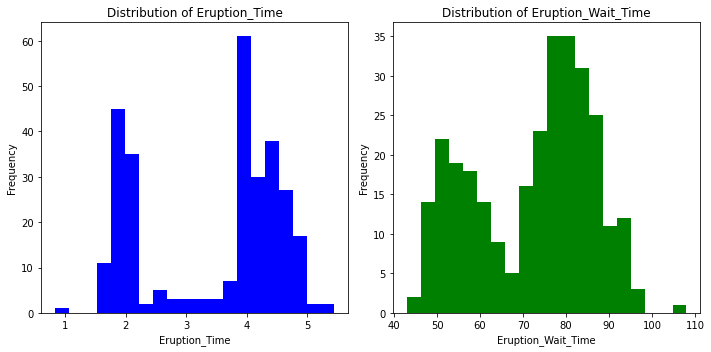

In [85]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].hist(df['Eruption_Time'], bins=20, color='blue')
axs[0].set_xlabel('Eruption_Time')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Eruption_Time')

axs[1].hist(df['Eruption_Wait_Time'], bins=20, color='green')
axs[1].set_xlabel('Eruption_Wait_Time')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Eruption_Wait_Time')

plt.tight_layout()
plt.show()

The distribution of both variables in the dataset follow a binomial pattern. Because of this, a hidden markov algorithm may not create the best model for predicting eruption time and wait time. A linear dynamic system might also not work because of similar issues with the data not hving a normal distribution. A mixture of Gaussian models may give the best results at predicting the next outcome.

### Problem 3. Modeling Data (25pts). 
Consider a data set consisting of the following string of 160 symbols from the alphabet {A, B, C}:
* AABBBACABBBACAAAAAAAAABBBACAAAAABACAAAAAABBBBACAAAAAAAA
* AAAABACABACAABBACAAABBBBACAAABACAAAABACAABACAAABBACAAAA
* BBBBACABBACAAAAAABACABACAAABACAABBBACAAAABACABBACA

Look carefully at the above string. Having analyzed the string, describe an HMM model for it. Your description should include the number of states in the HMM, the transition matrix including the values of the elements of the matrix, the emission matrix including the values of its elements, and the initial state probabilities. You need to provide some description/justification for how you arrived at these numbers. I am not expecting you to code the HMM algorithm—you should be able to answer this question just by examining the sequence carefully

In [86]:
string1 = 'AABBBACABBBACAAAAAAAAABBBACAAAAABACAAAAAABBBBACAAAAAAAA'
string2 = 'AAAABACABACAABBACAAABBBBACAAABACAAAABACAABACAAABBACAAAA'
string3 = 'BBBBACABBACAAAAAABACABACAAABACAABBBACAAAABACABBACA'

combined_string = string1 + string2 + string3

In [87]:
# Count the number of times each letter (A, B, and C) appears in the combined string
a_count = combined_string.count('A')
b_count = combined_string.count('B')
c_count = combined_string.count('C')

# Calculate the total number of letters in the sequence
total_count = len(combined_string)

# Calculate the probability of each letter
a_prob = round(a_count / total_count, 5)
b_prob = round(b_count / total_count, 5)
c_prob = round(c_count / total_count, 5)

# Print the probability matrix
print([a_prob], [b_prob], [c_prob], sep='\n')

[0.60625]
[0.2625]
[0.13125]


The Initial probability for the three states (A, B, and C) are:

|    |  |
|----|---|
| A  |0.606 |
| B  |0.263 |
| C  |0.131 |

In [94]:
count_matrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

for i in range(len(combined_string)-1):
    current_char = combined_string[i]
    next_char = combined_string[i+1]
    
    if current_char == 'A':
        if next_char == 'A':
            count_matrix[0][0] += 1
        elif next_char == 'B':
            count_matrix[0][1] += 1
        elif next_char == 'C':
            count_matrix[0][2] += 1
    elif current_char == 'B':
        if next_char == 'A':
            count_matrix[1][0] += 1
        elif next_char == 'B':
            count_matrix[1][1] += 1
        elif next_char == 'C':
            count_matrix[1][2] += 1
    elif current_char == 'C':
        if next_char == 'A':
            count_matrix[2][0] += 1
        elif next_char == 'B':
            count_matrix[2][1] += 1
        elif next_char == 'C':
            count_matrix[2][2] += 1
            
def calculate_prob_matrix(count_matrix):
    row_sums = np.sum(count_matrix, axis=1)
    prob_matrix = count_matrix / row_sums[:, np.newaxis]
    prob_matrix[np.isnan(prob_matrix)] = 0
    prob_matrix = np.round(prob_matrix, decimals=2)
    prob_matrix[prob_matrix == -np.inf] = 0
    return prob_matrix

print('Transitional Count Matrix')
for row in count_matrix:
    print(row)
print()
print('Transitional Probability Matrix')
prob_matrix = calculate_prob_matrix(count_matrix) 
print(prob_matrix)

Transitional Count Matrix
[54, 21, 21]
[21, 21, 0]
[21, 0, 0]

Transitional Probability Matrix
[[0.56 0.22 0.22]
 [0.5  0.5  0.  ]
 [1.   0.   0.  ]]


The Transitional probability matrix is as follows:

|    | A | B | C |
|----|---|---|---|
| A  |0.56 |0.22 |0.22 |
| B  |0.50 |0.50 |0  |
| C  |1 |0  |0  |

In [105]:
baca_count = combined_string.count('BACA')
print('Total number of BACA sequences:' ,baca_count)

baca_count_matrix = [[0], [0], [0]]

for i in range(len(combined_string)-3):
    current_char = combined_string[i]
    next_4_chars = combined_string[i+1:i+5]
    
    if next_4_chars == 'BACA':
        if current_char == 'A':
            baca_count_matrix[0][0] += 1
        elif current_char == 'B':
            baca_count_matrix[1][0] += 1
        elif current_char == 'C':
            baca_count_matrix[2][0] += 1

print('BACA Count Matrix')            
for row in baca_count_matrix:
    print(row)


baca_prob_matrix = [[0.0], [0.0], [0.0]]

for i in range(3):
    for j in range(1):
        baca_prob_matrix[i][j] = round(baca_count_matrix[i][j] / baca_count, 2)

print('BACA Probability matrix')        
for row in baca_prob_matrix:
    print(row)

Total number of BACA sequences: 21
BACA Count Matrix
[10]
[11]
[0]
BACA Probability matrix
[0.48]
[0.52]
[0.0]


The sequence 'BACA' shows up 21 times in all of the sequences. Hence, I will use it as my emission probability matrix. The counts and probabilities above are compared against the number of states (A, B, C). 

Emission Probability Matrix: 


|    | BACA |
|----|---|
| A  |0.48 |
| B  |0.52 |
| C  |0 |


One interesting observation of the data is that the letter C is always surrounded on both sides by the letter A, and is in all of the BACA sequences.

#### Problem 4. Expectation Maximization (25pts). 
Consider a data set of binary (black and white) images. Each image is arranged into a vector of pixels by concatenating the columns of pixels in the image.

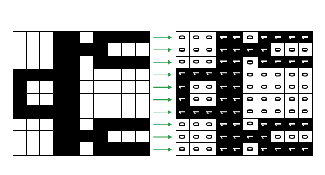

The data set has 𝑁 images {$𝑥^{(1)}$ , . . . , $𝑥^{(𝑁)}$} and each image has 𝐷 pixels, where 𝐷 is (number of rows X
number of columns) in the image. For example, image $𝑥^{(𝑛)}$ is a vector ($𝑥_{1}^{(𝑛)}$ , . . . , $𝑥_{𝐷}^{(𝑛)}$ ) where $𝑥_{𝑑}^{(𝑛)}$ ∈
{0, 1} for all 𝑛 ∈ {1, . . . , 𝑁} and 𝑑 ∈ {1, . . . , 𝐷}.

Write down the likelihood for a model consisting of a mixture of 𝐾 multivariate Bernoulli distributions.
Use the parameters $𝜋_{1}$, . . . , $𝜋_{𝐾}$ to denote the mixing proportions (0 ≤ $𝜋_{𝑘}$ ≤ 1; $∑_{k}𝜋_{𝑘}$ = 1) and arrange
the 𝐾 Bernoulli parameter vectors into a matrix 𝑃 with elements $𝑝_{𝑘𝑑}$ denoting the probability that pixel
𝑑 takes value 1 under mixture component 𝑘.

#### Answer

Based on the information given above, the following assumptions/ clarifications have been made:

* $𝜋_{𝑘}$ can be represented as the probability of k
* K is the number of multivariate Bernoulli distributions
* Probability of k ($𝜋_{𝑘}$) falls between 0 and 1 and the sum (∑) of all $𝜋_{𝑘}$ is equal to 1

Given the information above, the likelihood of the model is:
𝑃(𝑥|𝜋, 𝑝) = ∑𝑘=1^𝐾 $𝜋_{𝑘}$𝑃(𝑥|$𝑝_{𝑘}$)

𝑃(𝑥|$𝑝_{𝑘}$) is the probability density of the multivariate Bernoulli Distribution, which can be broken down further as:

𝑃(𝑥|$𝑝_{𝑘}$) = ∏𝑑=1^𝐷 $𝑝_{𝑘}$,𝑑^$𝑥_{𝑑}$(1 − $𝑝_{𝑘d}$)^(1−$𝑥_{𝑑}$)

Simply put, the multivariate Bernoulli Distribution equation above is the probability that a pixel (d) has a value of 1 (is black in the image), given the mixture of multivariate k